In [1]:
%matplotlib inline

In [2]:
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from torchvision import transforms, utils
from torch.autograd import Variable
from skimage import io
import matplotlib.pyplot as plt
import torch.nn.functional as F
from itertools import count
import torch.optim as optim
import torch.nn as nn
import torch.autograd
import pandas as pd
import numpy as np
import skimage
import torch
import cv2

In [3]:
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [4]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    landmarks = landmarks.cpu().numpy()
    plt.imshow(image.cpu().numpy(),cmap=plt.cm.gray)
    plt.scatter(landmarks[:, 0]*96, landmarks[:, 1]*96, s=0.7, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated


In [5]:
from visdom import Visdom

class VisdomLinePlotter(object):
    """Plots to Visdom"""

    def __init__(self, env_name='main'):
        self.viz = Visdom()
        self.env = env_name
        self.plots = {}
        self.scores_window = None

    def plot(self, var_name, split_name, x, y, x_label='Epochs'):
        if var_name not in self.plots:
            self.plots[var_name] = self.viz.line(X=np.array([x,x]), Y=np.array([y,y]), env=self.env, opts=dict(
                legend=[split_name],
                title=var_name,
                xlabel=x_label,
                ylabel=var_name
            ))
        else:
            self.viz.updateTrace(X=np.array([x]), Y=np.array([y]), env=self.env, win=self.plots[var_name], name=split_name)

In [6]:
class SurfDataset(Dataset):
    """ Landmarks dataset."""

    def __init__(self, csv_file, transform=None):
        self.landmarks_frame = pd.read_csv(csv_file,index_col=0,header=0)
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        row = self.landmarks_frame.loc[idx]
        img_name = row[1]
        
        image = cv2.imread(img_name,0)
        landmarks = row[2:].as_matrix()/96
        landmarks = np.array(landmarks,dtype=np.float)
        
        landmarks = landmarks.reshape(landmarks.shape[0]//2, 2)
        image = cv2.resize(image,(96,96))
        result = np.zeros((96,96))
        result = cv2.normalize(image, dst=result, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        sample = {'image': result, 'landmarks': landmarks}
        if self.transform:
            sample = self.transform(sample)

        return sample

In [7]:

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        
        return {'image': torch.Tensor(image),
                'landmarks': torch.Tensor(landmarks)}

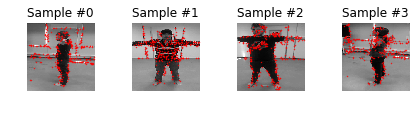

In [8]:
transform = transforms.Compose([ToTensor()])

surf_dataset = SurfDataset(csv_file='dataset_train.csv',transform=transform)
vis_dataloader = DataLoader(surf_dataset,
                        shuffle=True,
                        num_workers=4,
                        batch_size=10)
fig = plt.figure()

for i in range(len(surf_dataset)):
    sample = surf_dataset[i]
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)

    if i == 3:
        plt.show()
        break

In [9]:
class SurfNetwork(nn.Module):
    def __init__(self):
        super(SurfNetwork, self).__init__()
        self.cnn_1 = nn.Sequential(
            nn.Conv2d(1,32,(4,4)),
            nn.Conv2d(32,32,(4,4)),
            nn.MaxPool2d(2),
            nn.Dropout2d(p=.2),
            nn.Conv2d(32,32,(3,3)),
            nn.Conv2d(32,32,(3,3)),
            nn.MaxPool2d(2),
            nn.Dropout2d(p=.2),
            nn.Conv2d(32,64,(3,3)),
            nn.Conv2d(64,64,(3,3)),
            nn.MaxPool2d(2),
            nn.Dropout2d(p=.3),
            #nn.Linear(in_features=8*8,out_features=700)
        )
        self.cnn_2 = nn.Sequential(
            nn.Linear(4096, 1500),
            nn.ReLU(inplace=True),
            nn.Linear(1500, 700)
         )
    def forward(self, xs,batch_size):
        outputs = Variable(torch.zeros(batch_size,1,700)).cuda()
        xs = xs.view(batch_size,1,96,96)
        for i, x in enumerate(xs):
            x = x.view(1, 1, 96, 96)
            output = self.cnn_1(x)
            output = output.view(output.size()[0], -1)
            output = self.cnn_2(output)
            outputs[i] = output
        return outputs

In [27]:
net = SurfNetwork().cuda()
criterion = torch.nn.MSELoss(size_average=True)

#optimizer = optim.Adam(net.parameters(),lr = 0.0005 )
#criterion = ContrastiveLoss()

In [72]:
optimizer = torch.optim.SGD(net.parameters(), lr=1e4, momentum=0.9)

In [28]:
counter = []
loss_history = [] 
iteration_number= 0

In [73]:
plotter = VisdomLinePlotter(env_name="test")

for epoch in range(300):
    sum_batch = 0
    for i, data in enumerate(vis_dataloader):
        img = data["image"]
        label = data["landmarks"]
        img, label = Variable(img).cuda(), Variable(label).cuda()
        output = net(img,img.size()[0])
        loss = criterion(output.view(img.size()[0], 700), label.view(img.size()[0], 700))
        #print(output,label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        sum_batch += loss.data[0]
        if(epoch > 10):
            plotter.plot('minibatch loss', str(epoch+1), i, loss.data[0], 'minibatch')
    
    if(epoch > 10):
        plotter.plot('Epochs loss', "Epochs", epoch, sum_batch/(i+1), 'Epochs')

RuntimeError: unspecified launch failure

In [63]:
torch.save(net.state_dict(), "./{}_{}.pkl".format("checkpoints", 1200))

In [64]:
x = img[1]
y_real = label[1].cpu().data.numpy()
y_pred = net(x,1)[0].cpu().data.numpy().reshape((350,2))
x = x.cpu().data.numpy()

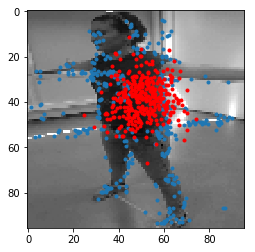

In [65]:
plt.imshow(x,cmap=plt.cm.gray)
plt.plot(y_real[:,0] * 96,y_real[:,1]* 96,'.')
plt.plot(y_pred[:,0]*96, y_pred[:,1]*96,'.r')

In [66]:
surf_dataset_test = SurfDataset(csv_file='dataset_test.csv',transform=transform)
vis_dataloader_test = DataLoader(surf_dataset_test,
                        shuffle=True,
                        num_workers=1,
                        batch_size=1)


In [67]:
surf_dataset_test.__len__()

51

In [68]:
y = []
y_pred = []
for i, data in enumerate(vis_dataloader_test):
    img = data["image"]
    label = data["landmarks"]
    img, label = Variable(img).cuda(), Variable(label).cuda()
    output = net(img,img.size()[0])
    loss = criterion(output.view(img.size()[0], 700), label.view(img.size()[0], 700))
    y.append(label.cpu().data.numpy())
    y_pred.append(output.cpu().data.numpy())
    print("Current loss {}\n".format(loss.data[0]))

Current loss 0.05538024380803108

Current loss 0.03500065952539444

Current loss 0.0630878135561943

Current loss 0.06688058376312256

Current loss 0.0587596669793129

Current loss 0.05123360827565193

Current loss 0.07234551757574081

Current loss 0.07023841887712479

Current loss 0.048342715948820114

Current loss 0.05372157320380211

Current loss 0.04801609739661217

Current loss 0.05078442022204399

Current loss 0.07467096298933029

Current loss 0.07599064707756042

Current loss 0.04787671938538551

Current loss 0.048709023743867874

Current loss 0.05821184441447258

Current loss 0.057840362191200256

Current loss 0.05292481556534767

Current loss 0.06522640585899353

Current loss 0.07503613084554672

Current loss 0.10150523483753204

Current loss 0.05965825170278549

Current loss 0.06849317997694016

Current loss 0.06440550833940506

Current loss 0.05912251025438309

Current loss 0.06473991274833679

Current loss 0.07231301069259644

Current loss 0.06407131999731064

Current loss 

In [69]:
y = np.array(y)
y_test = y.reshape(y.shape[0],y.shape[1]*y.shape[2]*y.shape[3])

In [70]:
y_pred = np.array(y_pred)
y_pred = y_pred.reshape(y_pred.shape[0],y_pred.shape[1]*y_pred.shape[2]*y_pred.shape[3])

In [71]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
print(np.sqrt(mean_squared_error(y_test, y_pred)))
print(explained_variance_score(y_test.ravel(), y_pred.ravel()))
#print mean_absolute_error(y_test, y_pred)
print(r2_score(y_test, y_pred)) 

0.24394
-0.110783338547
-0.181852483171
